In [1]:
import pandas as pd
import glob
import statsmodels.api as sm
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot
from datetime import datetime
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_percentage_error

In [2]:
archivos = glob.glob('dataset/*.csv') #agrupo todos los csv
archivos_ordenados = sorted(archivos, key=lambda x: x.split('_')[3]) #ordeno por YYYMM de forma asc

In [3]:
dataframes = []
for archivo in archivos_ordenados: # junto todos los csv
    df = pd.read_csv(archivo, header=None, sep=';')
    dataframes.append(df)

data = pd.concat(dataframes, ignore_index=True)

nombres_columnas = ['ID', 'Date', 'Consumo', 'Flag', 'Muestra', 'Nombre_Interruptor']
data.columns = nombres_columnas + list(range(len(nombres_columnas), len(data.columns)))

In [4]:
def remove_timezone(date_str):
    return re.sub(r'\s*[-+]\d{4}', '', date_str)
data["Date"] = data["Date"].apply(remove_timezone)
data["Date"] = pd.to_datetime(data["Date"], format="%Y-%m-%d %H:%M:%S")

In [ ]:
valores_faltantes = data.isnull().sum()
proporcion_faltantes = valores_faltantes / len(data) * 100
print("Valores faltantes por columna:")
print(proporcion_faltantes)

# Identificar las columnas con valores faltantes
columnas_con_faltantes = valores_faltantes[valores_faltantes > 0].index.tolist()
print("\nColumnas con valores faltantes:")
print(columnas_con_faltantes)

# Evaluar el impacto de los valores faltantes en tu análisis
# Aquí puedes realizar análisis específicos para cada columna con valores faltantes y determinar su importancia

# Considerar estrategias para manejar los valores faltantes
# Por ejemplo, puedes imputar los valores faltantes con la media o la mediana de la columna, eliminar filas con valores faltantes, etc.
# Aquí hay un ejemplo de imputación de valores faltantes con la media de la columna "columna_con_faltantes":
datos_imputados = data.copy()
for columna in columnas_con_faltantes:
    media = data[columna].mean()
    datos_imputados[columna].fillna(media, inplace=True)

Valores faltantes por columna:
ID                    0.0
Date                  0.0
Consumo               0.0
Flag                  0.0
Muestra               0.0
Nombre_Interruptor    0.0
dtype: float64

Columnas con valores faltantes:
[]


In [ ]:
data.head(10)

,ID,Date,Consumo,Flag,Muestra,Nombre_Interruptor
0,177760211,2017-02-28 15:00:00,-28.206767,1,4,AJAHUEL 110 H1 P
1,395102211,2017-02-28 15:00:00,-236.467353,1,4,BUIN 110 HT1 MTP
2,395684211,2017-02-28 15:00:00,126.075465,1,4,BUIN 110 H2 P
3,397670211,2017-02-28 15:00:00,81.017303,1,4,LOSALME 110 H1 P
4,397693211,2017-02-28 15:00:00,69.876691,1,4,LOSALME 110 H3 P
5,397712211,2017-02-28 15:00:00,74.248916,1,4,LOSALME 110 H4 P
6,400203211,2017-02-28 15:00:00,30.345499,1,4,LOSALME 110 H2 P
7,433388211,2017-02-28 15:00:00,158.178446,1,4,CHENA 110 H1 P
8,393655211,2017-02-28 15:00:00,109.541742,1,4,BUIN 110 H1 P
9,433398211,2017-02-28 15:00:00,129.607846,1,4,CHENA 110 H2 P


In [5]:
split_data = data['Nombre_Interruptor'].str.split()

data['Barra'] = split_data.str[0]
data['Subestacion'] = split_data.str[1].str.join(' ')
data['Interruptor'] = split_data.str[2:].str.join(' ')

data.drop(columns=['Nombre_Interruptor'], inplace=True)

In [ ]:
data

,ID,Date,Consumo,Flag,Muestra,Barra,Subestacion,Interruptor
0,177760211,2017-02-28 15:00:00,-28.206767,1,4,AJAHUEL,1 1 0,H1 P
1,395102211,2017-02-28 15:00:00,-236.467353,1,4,BUIN,1 1 0,HT1 MTP
2,395684211,2017-02-28 15:00:00,126.075465,1,4,BUIN,1 1 0,H2 P
3,397670211,2017-02-28 15:00:00,81.017303,1,4,LOSALME,1 1 0,H1 P
4,397693211,2017-02-28 15:00:00,69.876691,1,4,LOSALME,1 1 0,H3 P
...,...,...,...,...,...,...,...,...
2242963,387377211,2023-06-27 23:00:00,9.554752,1,4,FLORIDA,1 1 0,H3 P
2242964,387401211,2023-06-27 23:00:00,-24.972685,1,4,FLORIDA,1 1 0,H4 P
2242965,392490211,2023-06-27 23:00:00,-39.438634,1,4,FLORIDA,1 1 0,H8 P
2242966,392509211,2023-06-27 23:00:00,37.972639,1,4,FLORIDA,1 1 0,H7 P


In [ ]:
# Verificar la consistencia de los datos en cada columna
consistencia_columnas = data.apply(lambda x: x.nunique())
print("Número de valores únicos por columna:")
print(consistencia_columnas)


Número de valores únicos por columna:
ID                  39
Date             55296
Consumo        1970970
Flag                 3
Muestra              5
Barra                7
Subestacion          1
Interruptor         12
dtype: int64


In [ ]:
# Realizar análisis estadístico para identificar datos atípicos
analisis_estadistico = data.describe()
print("Análisis estadístico de los datos:")
print(analisis_estadistico)


Análisis estadístico de los datos:
                 ID                           Date       Consumo  \
count  2.242968e+06                        2242968  2.242968e+06   
mean   3.617996e+08  2020-05-25 17:45:27.354291456  3.233541e+01   
min    1.777602e+08            2017-02-28 15:00:00 -5.970000e+02   
25%    2.255402e+08            2018-10-21 05:45:00 -3.062436e+00   
50%    3.925612e+08            2020-06-11 06:30:00  4.379763e+01   
75%    4.333882e+08            2022-02-05 23:15:00  8.145555e+01   
max    8.546412e+08            2023-06-27 23:00:00  3.199903e+02   
std    1.257530e+08                            NaN  7.411118e+01   

               Flag       Muestra  
count  2.242968e+06  2.242968e+06  
mean   9.889330e-01  3.940358e+00  
min    0.000000e+00  0.000000e+00  
25%    1.000000e+00  4.000000e+00  
50%    1.000000e+00  4.000000e+00  
75%    1.000000e+00  4.000000e+00  
max    3.300000e+01  4.000000e+00  
std    5.571145e-01  4.551701e-01  


In [ ]:
valor_minimo = data['Consumo'].min()
print(f'Valor Mínimo: {valor_minimo}')
valor_maximo = data['Consumo'].max()
print(f'Valor Máximo: {valor_maximo}')
columna_especifica = data['Consumo']
rangos_validos = (data['Consumo'] >= valor_minimo) & (data['Consumo'] <= valor_maximo)
datos_inconsistentes = data[~rangos_validos]
print(f'Datos columna Consumo:')
print(columna_especifica)
print(f'Datos inconsistentes: {datos_inconsistentes}')
print('\n')

Valor Mínimo: -597.0
Valor Máximo: 319.990285
Datos columna Consumo:
0          -28.206767
1         -236.467353
2          126.075465
3           81.017303
4           69.876691
              ...    
2242963      9.554752
2242964    -24.972685
2242965    -39.438634
2242966     37.972639
2242967     -0.113527
Name: Consumo, Length: 2242968, dtype: float64
Datos inconsistentes: Empty DataFrame
Columns: [ID, Date, Consumo, Flag, Muestra, Barra, Subestacion, Interruptor]
Index: []




In [6]:
consumo = data.groupby(['Barra', 'Date'])['Consumo'].sum().reset_index()
#consumo=consumo.set_index("Fecha_Hora")

In [ ]:
consumo

,Barra,Date,Consumo
0,AJAHUEL,2017-02-28 15:00:00,179.705306
1,AJAHUEL,2017-02-28 16:00:00,184.789336
2,AJAHUEL,2017-02-28 17:00:00,187.619336
3,AJAHUEL,2017-02-28 18:00:00,182.389885
4,AJAHUEL,2017-02-28 19:00:00,173.051792
...,...,...,...
387067,LOSALME,2023-06-27 19:00:00,216.470914
387068,LOSALME,2023-06-27 20:00:00,213.860067
387069,LOSALME,2023-06-27 21:00:00,209.034960
387070,LOSALME,2023-06-27 22:00:00,199.870564


In [ ]:
# Calcular el rango intercuartílico (IQR)
Q1 = consumo['Consumo'].quantile(0.25)
Q3 = consumo['Consumo'].quantile(0.75)
IQR = Q3 - Q1

# Calcular los límites inferior y superior para identificar outliers
lower_bound = Q1 - 2.0 * IQR
upper_bound = Q3 + 2.0 * IQR

# Filtrar el dataset para excluir outliers
without_me = consumo[(consumo['Consumo'] >= lower_bound) & (consumo['Consumo'] <= upper_bound)]


In [ ]:
without_me.info()

<class 'pandas.core.frame.DataFrame'>
Index: 384738 entries, 0 to 387071
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype         
---  ------   --------------   -----         
 0   Barra    384738 non-null  object        
 1   Date     384738 non-null  datetime64[ns]
 2   Consumo  384738 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 11.7+ MB


In [7]:
entrenamiento=consumo.query("Date.dt.year>2017 and Date.dt.year<2022")
validacion=consumo.query("Date.dt.year==2022")

In [ ]:
#sin outlayers
train_out=consumo.query("Date.dt.year>2017 and Date.dt.year<2022")
test_out=consumo.query("Date.dt.year==2022")

Q1_train = train_out['Consumo'].quantile(0.25)
Q3_train = train_out['Consumo'].quantile(0.75)
IQR_train = Q3_train - Q1_train

Q1_test = test_out['Consumo'].quantile(0.25)
Q3_test = test_out['Consumo'].quantile(0.75)
IQR_test = Q3_test - Q1_test

# Calcular los límites inferior y superior para identificar outliers
lower_bound_train= Q1_train - 1.5 * IQR_train
upper_bound_train = Q3_train + 1.5 * IQR_train

lower_bound_test = Q1_test - 1.5 * IQR_test
upper_bound_test = Q3_test + 1.5 * IQR_test

# Filtrar el dataset para excluir outliers
train_out = train_out[(train_out['Consumo'] >= lower_bound_train) & (train_out['Consumo'] <= upper_bound_train)]
test_out = test_out[(test_out['Consumo'] >= lower_bound_test) & (test_out['Consumo'] <= upper_bound_test)]

In [8]:
entrenamiento["Date"]=pd.to_datetime(entrenamiento["Date"],format="%Y-%m-%d %H:%M:%S")
ds_train=entrenamiento.set_index("Date")

validacion["Date"]=pd.to_datetime(validacion["Date"],format="%Y-%m-%d %H:%M:%S")
ds_test=validacion.set_index("Date")

<ipython-input-8-0bd81b097536>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entrenamiento["Date"]=pd.to_datetime(entrenamiento["Date"],format="%Y-%m-%d %H:%M:%S")
<ipython-input-8-0bd81b097536>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validacion["Date"]=pd.to_datetime(validacion["Date"],format="%Y-%m-%d %H:%M:%S")


In [9]:
train_out["Date"]=pd.to_datetime(train_out["Date"],format="%Y-%m-%d %H:%M:%S")
ds_train_out=train_out.set_index("Date")

test_out["Date"]=pd.to_datetime(test_out["Date"],format="%Y-%m-%d %H:%M:%S")
ds_test_out=test_out.set_index("Date")

NameError: name 'train_out' is not defined

In [ ]:
ds_train

,Barra,Consumo
Date,,
2018-01-01 00:00:00,AJAHUEL,137.330840
2018-01-01 01:00:00,AJAHUEL,124.045549
2018-01-01 02:00:00,AJAHUEL,118.137811
2018-01-01 03:00:00,AJAHUEL,107.899499
2018-01-01 04:00:00,AJAHUEL,100.362069
...,...,...
2021-12-31 19:00:00,LOSALME,168.644175
2021-12-31 20:00:00,LOSALME,171.593959
2021-12-31 21:00:00,LOSALME,160.167061


In [ ]:
ds_train_out

,Barra,Consumo
Date,,
2018-01-01 00:00:00,AJAHUEL,137.330840
2018-01-01 01:00:00,AJAHUEL,124.045549
2018-01-01 02:00:00,AJAHUEL,118.137811
2018-01-01 03:00:00,AJAHUEL,107.899499
2018-01-01 04:00:00,AJAHUEL,100.362069
...,...,...
2021-12-31 19:00:00,LOSALME,168.644175
2021-12-31 20:00:00,LOSALME,171.593959
2021-12-31 21:00:00,LOSALME,160.167061


In [ ]:
#sin outlayers
train_out["Date"]=pd.to_datetime(train_out["Date"],format="%Y-%m-%d %H:%M:%S")
ds_train_out=train_out.set_index("Date")

test_out["Date"]=pd.to_datetime(test_out["Date"],format="%Y-%m-%d %H:%M:%S")
ds_test_out=test_out.set_index("Date")

<ipython-input-179-8cca01920b76>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_out["Date"]=pd.to_datetime(train_out["Date"],format="%Y-%m-%d %H:%M:%S")
<ipython-input-179-8cca01920b76>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_out["Date"]=pd.to_datetime(test_out["Date"],format="%Y-%m-%d %H:%M:%S")


In [ ]:
subestacion='AJAHUEL'
filtro="Barra=='{0}'".format(subestacion)
y_ajahuel=ds_train.query(filtro)["Consumo"]
x_ajahuel=ds_train.query(filtro).index
yt_ajahuel=ds_test.query(filtro)["Consumo"]
xt_ajahuel=ds_test.query(filtro).index
fig, axes = plt.subplots(2,1)
fig.set_size_inches(15, 8)
axes[0].plot(x_ajahuel,y_ajahuel);
axes[1].plot(xt_ajahuel,yt_ajahuel);
fig, axes = plt.subplots(1,2)
fig.set_size_inches(15, 5)
plot_acf(y_ajahuel,lags=7,ax=axes[0]);
plot_pacf(y_ajahuel,lags=7,method="ywm",ax=axes[1]);


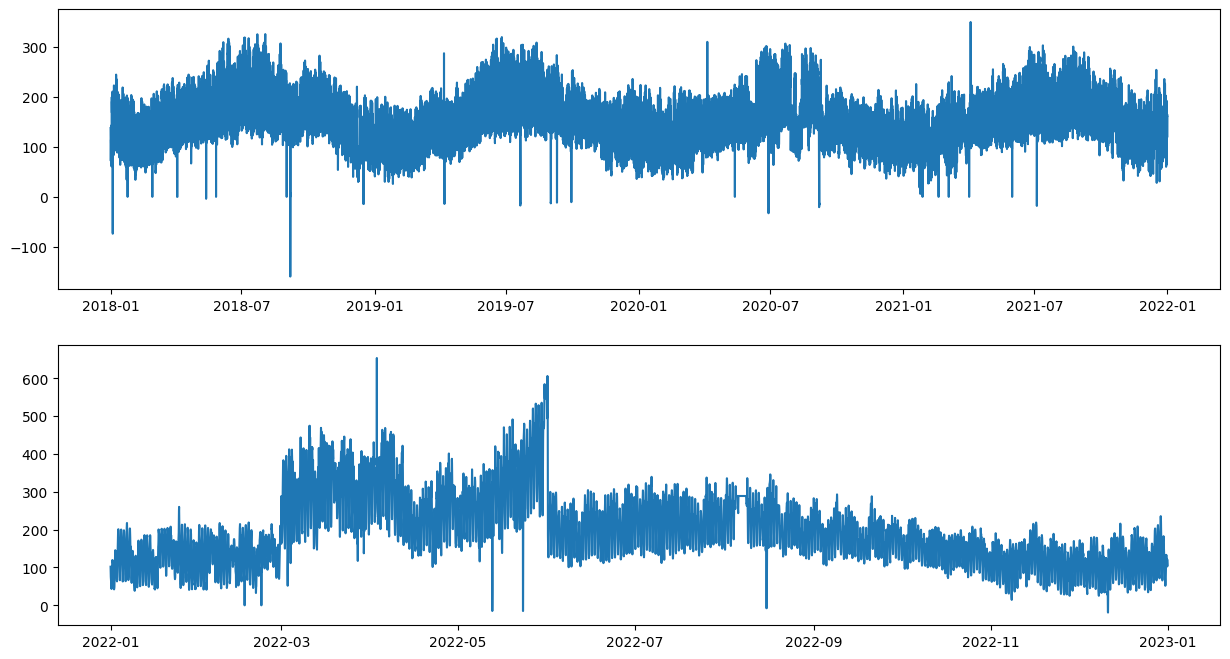

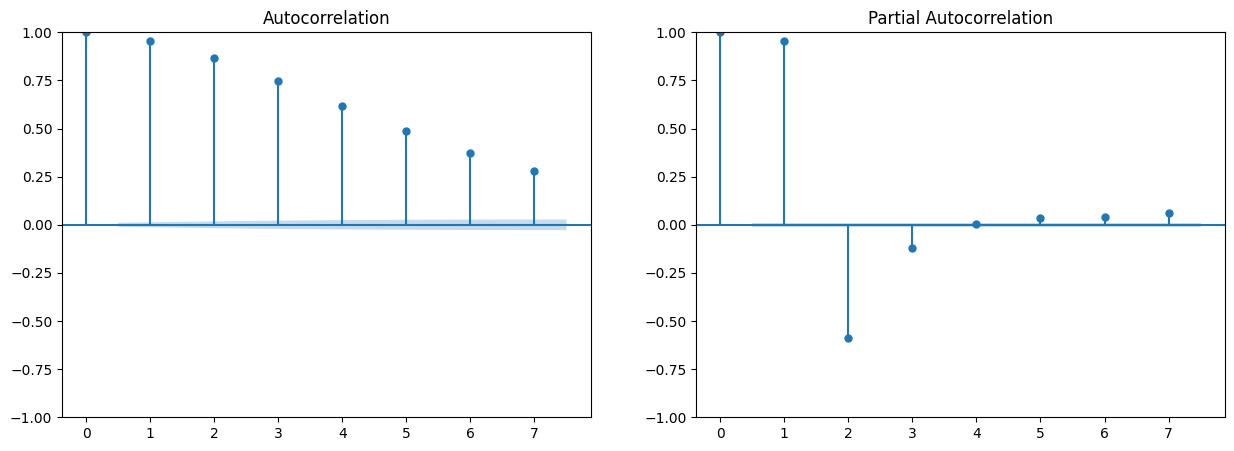

In [ ]:
#sin outlayers
subestacion_out='AJAHUEL'
filtro="Barra=='{0}'".format(subestacion_out)
y_ajahuel_out=ds_train_out.query(filtro)["Consumo"]
x_ajahuel_out=ds_train_out.query(filtro).index
yt_ajahuel_out=ds_test_out.query(filtro)["Consumo"]
xt_ajahuel_out=ds_test_out.query(filtro).index
fig, axes = plt.subplots(2,1)
fig.set_size_inches(15, 8)
axes[0].plot(x_ajahuel_out,y_ajahuel_out);
axes[1].plot(xt_ajahuel_out,yt_ajahuel_out);
fig, axes = plt.subplots(1,2)
fig.set_size_inches(15, 5)
plot_acf(y_ajahuel_out,lags=7,ax=axes[0]);
plot_pacf(y_ajahuel_out,lags=7,method="ywm",ax=axes[1]);

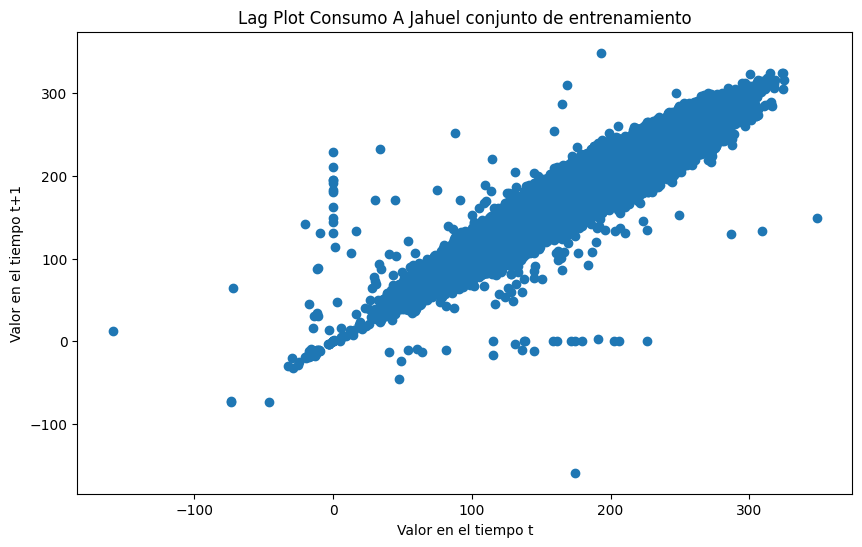

In [ ]:
plt.figure(figsize=(10, 6))
lag_plot(y_ajahuel, lag=1)  # Puedes ajustar el valor de 'lag' según tus necesidades
plt.title('Lag Plot Consumo A Jahuel conjunto de entrenamiento')
plt.xlabel('Valor en el tiempo t')
plt.ylabel('Valor en el tiempo t+1')
plt.show()

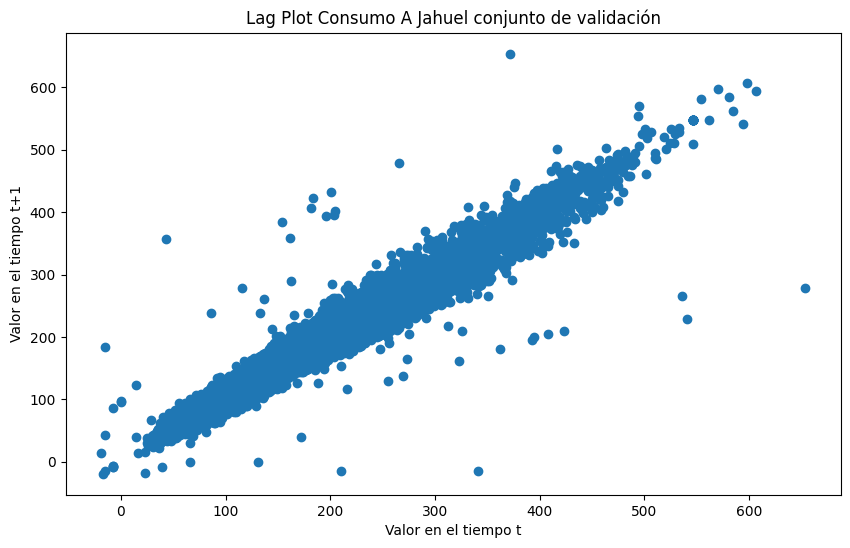

In [ ]:
plt.figure(figsize=(10, 6))
lag_plot(yt_ajahuel, lag=1)  # Puedes ajustar el valor de 'lag' según tus necesidades
plt.title('Lag Plot Consumo A Jahuel conjunto de validación')
plt.xlabel('Valor en el tiempo t')
plt.ylabel('Valor en el tiempo t+1')
plt.show()

<Axes: xlabel='Hora', ylabel='Consumo'>

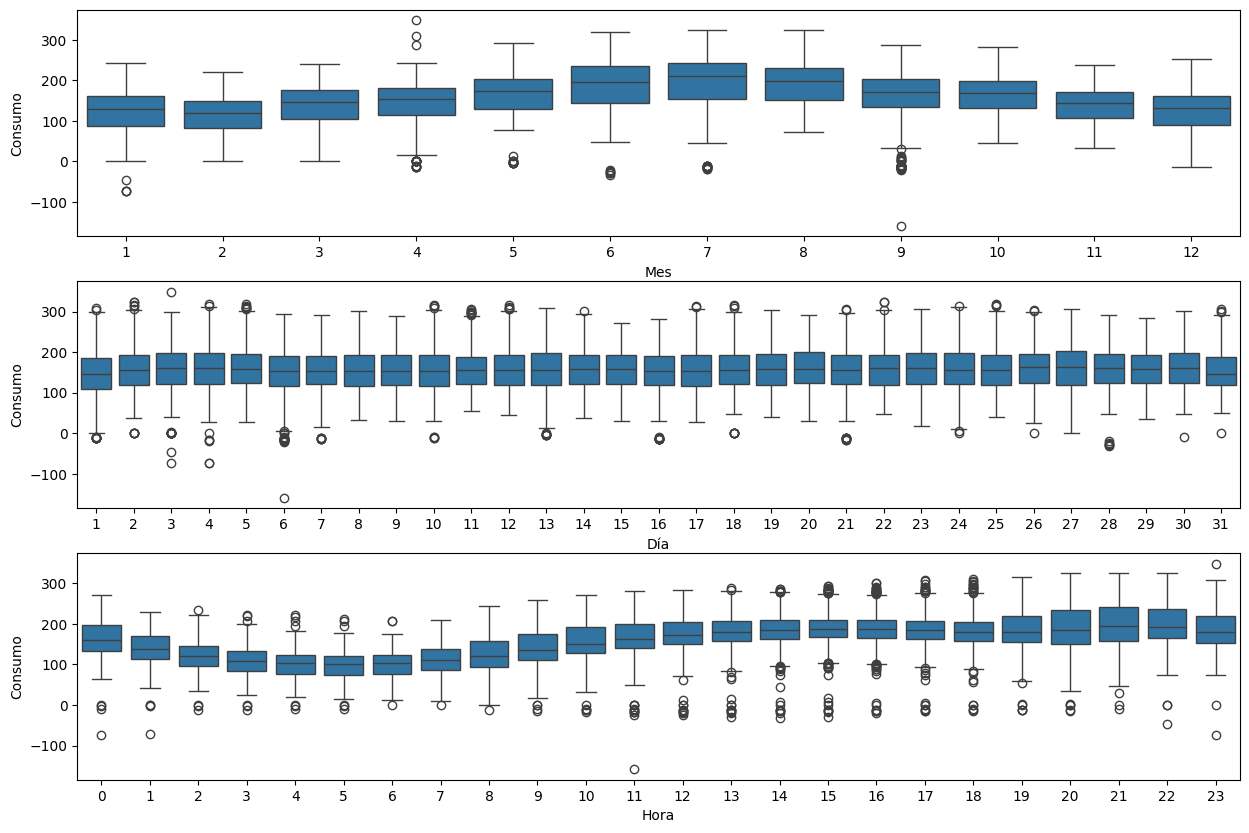

In [ ]:
data_ajahuel=pd.DataFrame()
data_ajahuel["Consumo"]=y_ajahuel
data_ajahuel["Date"]=y_ajahuel.index
data_ajahuel["Día"]=data_ajahuel["Date"].dt.day
data_ajahuel["Hora"]=data_ajahuel["Date"].dt.hour
data_ajahuel["Mes"]=data_ajahuel["Date"].dt.month

fig, axes = plt.subplots(3,1)
fig.set_size_inches(15, 10)

sns.boxplot(x="Mes", y="Consumo", data=data_ajahuel, ax=axes[0])
sns.boxplot(x="Día", y="Consumo", data=data_ajahuel, ax=axes[1])
sns.boxplot(x="Hora", y="Consumo", data=data_ajahuel, ax=axes[2])

In [ ]:
data_ajahuel["Año"]=data_ajahuel["Date"].dt.year
data_ajahuel

,Consumo,Date,Día,Hora,Mes,Año
Date,,,,,,
2018-01-01 00:00:00,137.330840,2018-01-01 00:00:00,1,0,1,2018
2018-01-01 01:00:00,124.045549,2018-01-01 01:00:00,1,1,1,2018
2018-01-01 02:00:00,118.137811,2018-01-01 02:00:00,1,2,1,2018
2018-01-01 03:00:00,107.899499,2018-01-01 03:00:00,1,3,1,2018
2018-01-01 04:00:00,100.362069,2018-01-01 04:00:00,1,4,1,2018
...,...,...,...,...,...,...
2021-12-31 19:00:00,157.753424,2021-12-31 19:00:00,31,19,12,2021
2021-12-31 20:00:00,132.997811,2021-12-31 20:00:00,31,20,12,2021
2021-12-31 21:00:00,132.565346,2021-12-31 21:00:00,31,21,12,2021


In [ ]:
data_ys_ajahuel=data_ajahuel[["Año","Mes","Día","Consumo"]].groupby(["Año","Mes","Día"]).agg("mean")
data_ys_ajahuel.to_csv("data_ys_ajahuel.csv")

In [ ]:
data_ys_ajahuel

Consumo
Año  Mes Día            
2018 1   1    103.311114
         2    138.795583
         3    123.858912
         4    133.034709
         5    162.777800
...                  ...
2021 12  27   167.009988
         28   168.701404
         29   154.095288
         30   129.945935
         31   122.579046

[1461 rows x 1 columns]

In [ ]:
ys_ajahuel=[]
xs_ajahuel=[]
archivo=open("data_ys_ajahuel.csv")
archivo.readline()
for linea in archivo:
    linea=linea.strip().split(",")
    ys_ajahuel.append(float(linea[3]))
    fecha=str(linea[0])+"-"+str(linea[1]).zfill(2)+"-"+str(linea[2]).zfill(2)
    xs_ajahuel.append(datetime.strptime(fecha,"%Y-%m-%d"))

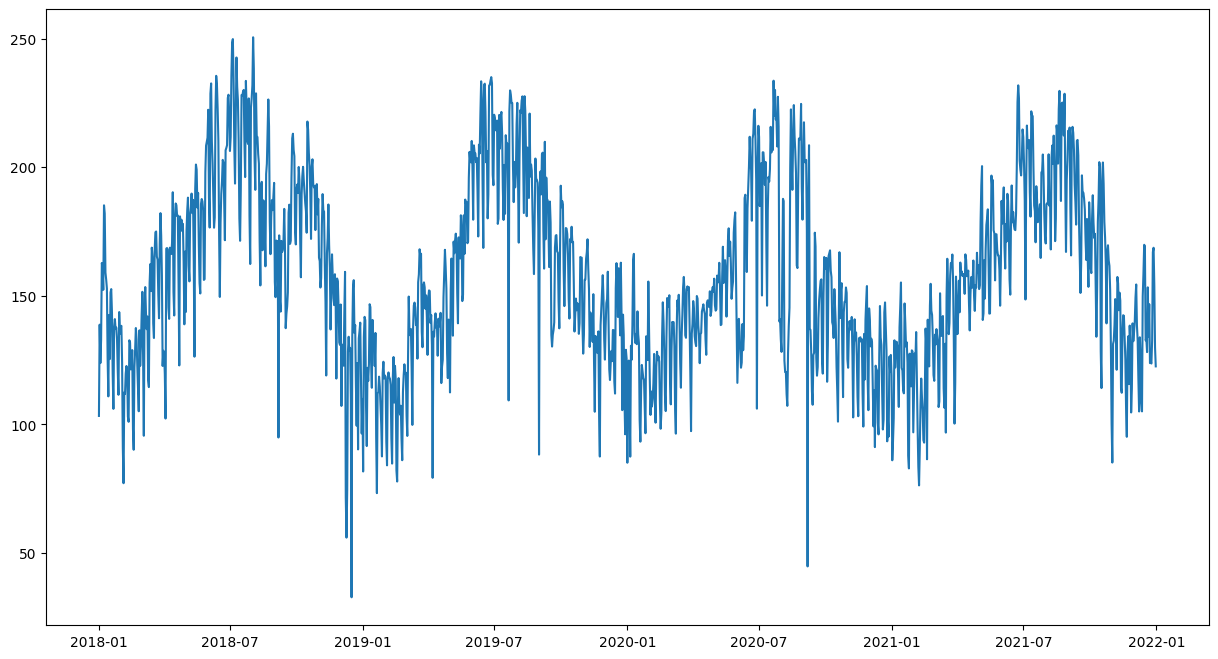

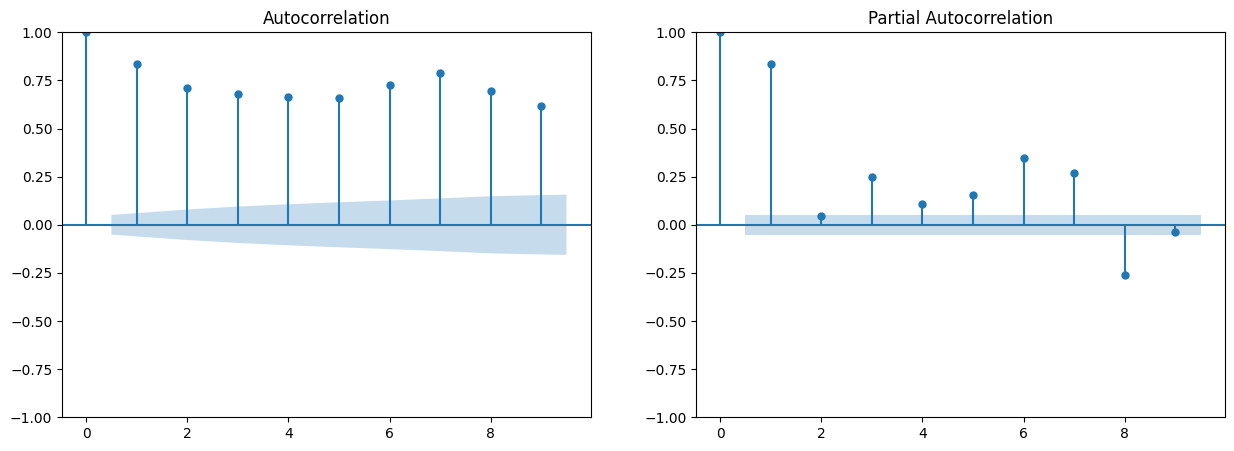

In [ ]:
fig, axes = plt.subplots(1,1)
fig.set_size_inches(15, 8)
axes.plot(xs_ajahuel,ys_ajahuel);
fig, axes = plt.subplots(1,2)
fig.set_size_inches(15, 5)
plot_acf(ys_ajahuel,lags=9,ax=axes[0]);
plot_pacf(ys_ajahuel,lags=9,method="ywm",ax=axes[1]);

In [ ]:
result = kpss(ys_ajahuel)

# Imprimir los resultados
print('KPSS Statistic:', result[0])
print('p-value:', result[1])
def funcion(x):
    if x<0.05:
        print("La serie no es estacionaria")
    else:
        print("La serie es estacionaria")
funcion(result[1])

KPSS Statistic: 0.17318667233630672
p-value: 0.1
La serie es estacionaria


<ipython-input-15-9f7f981d3dce>:1: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(ys_ajahuel)


**Modelo ARIMA**

In [ ]:
modelo_ajahuel_d=ARIMA(ys_ajahuel,order=(8,0,8))
m_ad1=modelo_ajahuel_d.fit()
print("MSE",m_ad1.mse)
print("AIC",m_ad1.aic)
ysp_ajahuel=m_ad1.predict()
mape=mean_absolute_percentage_error(ys_ajahuel,ysp_ajahuel)
print("MAPE",mape)

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


MSE 217.61616201090504
AIC 12040.619854081535
MAPE 0.0724707510343487


In [ ]:
#sin outlayers
modelo_ajahuel_d_out=ARIMA(ys_ajahuel_out,order=(8,0,8))
m_ad1_out=modelo_ajahuel_d_out.fit()
print("MSE",m_ad1_out.mse)
print("AIC",m_ad1_out.aic)
ysp_ajahuel_out=m_ad1_out.predict()
mape_out=mean_absolute_percentage_error(ys_ajahuel_out,ysp_ajahuel_out)
print("MAPE",mape_out)

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


MSE 217.61616201090504
AIC 12040.619854081535
MAPE 0.0724707510343487


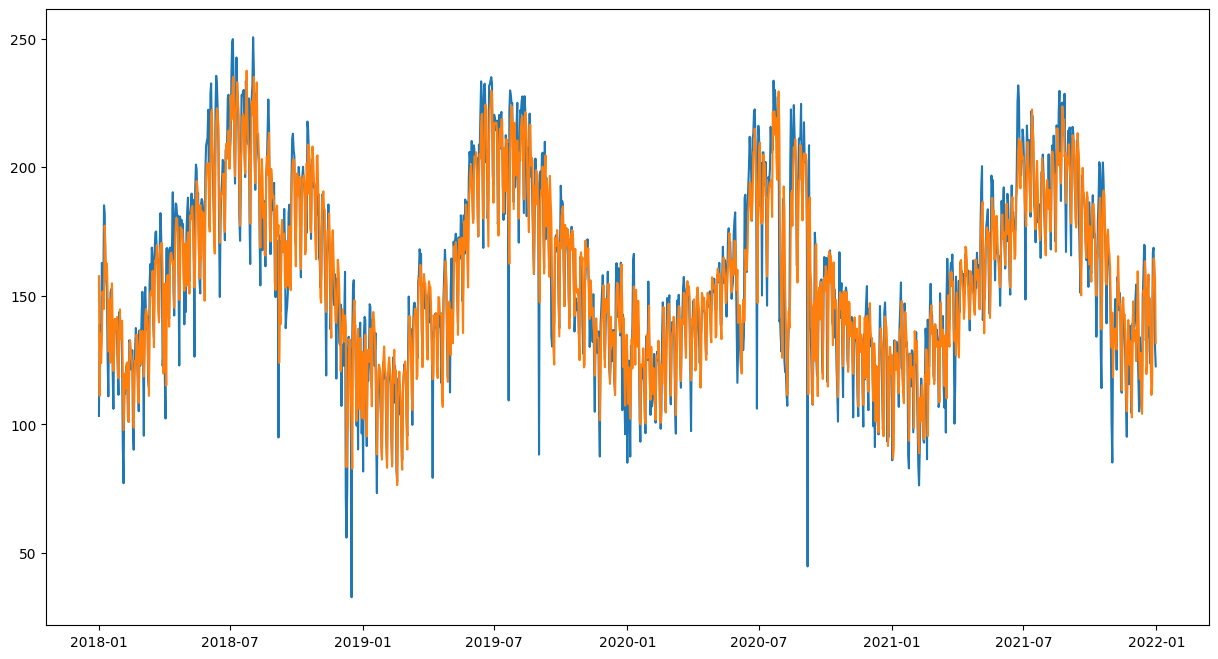

In [ ]:
fig, axes = plt.subplots(1,1)
fig.set_size_inches(15, 8)
axes.plot(xs_ajahuel,ys_ajahuel,xs_ajahuel,ysp_ajahuel);

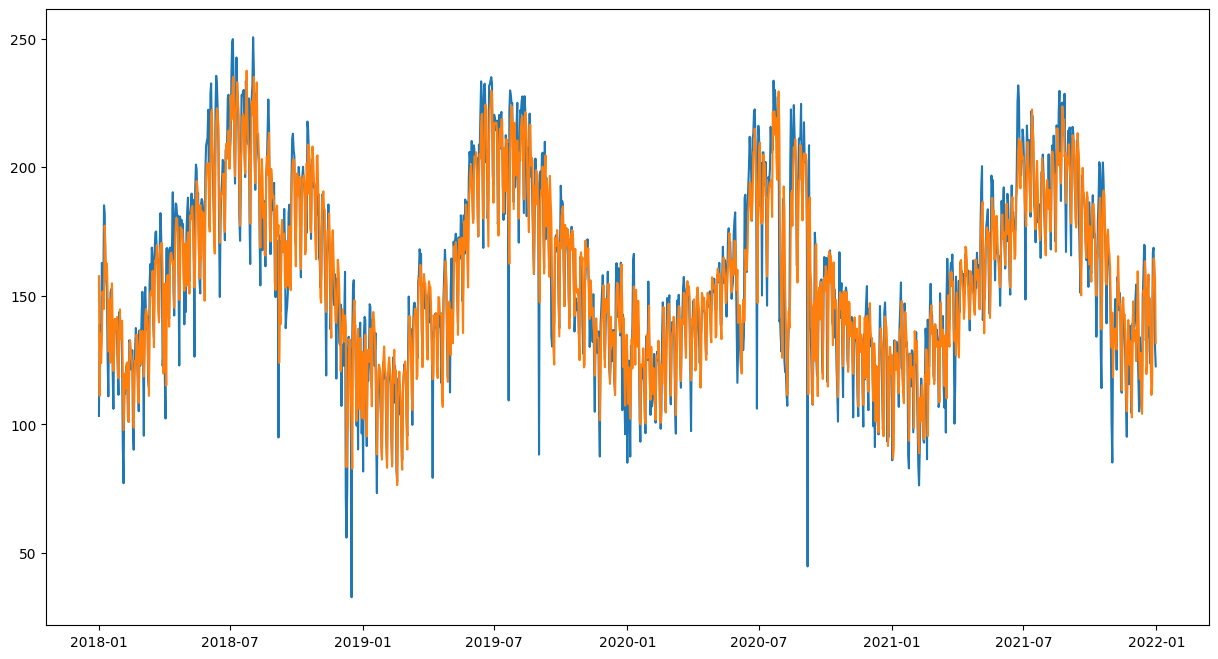

In [ ]:
#sin outlayers
fig, axes = plt.subplots(1,1)
fig.set_size_inches(15, 8)
axes.plot(xs_ajahuel_out,ys_ajahuel_out,xs_ajahuel_out,ysp_ajahuel_out);

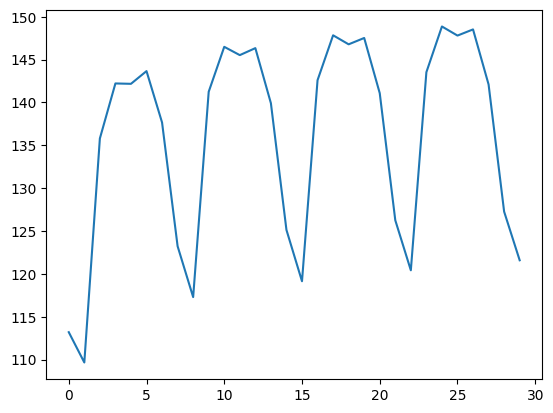

In [ ]:
m1_y1_p = m_ad1.get_forecast(steps=30)
m1_y1_ci = m_ad1.conf_int(0.05)
plt.plot(m1_y1_p.predicted_mean)

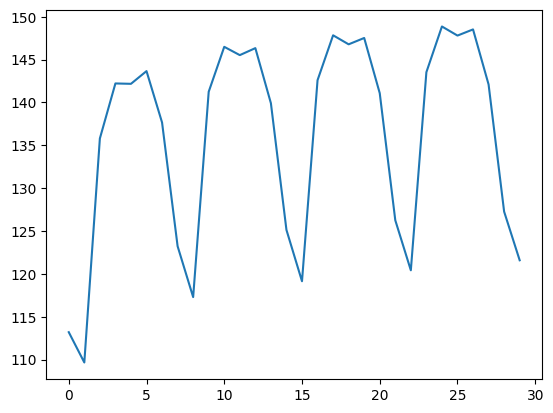

In [ ]:
#sin outlayers
m1_y1_p_out = m_ad1_out.get_forecast(steps=30)
m1_y1_ci_out = m_ad1_out.conf_int(0.05)
plt.plot(m1_y1_p_out.predicted_mean)

**Modelo Redes Neuronales RNN**

In [ ]:
yw_ajahuel=[]
yt_ajahuel=[]
window=8
for i in range(0,len(ys_ajahuel)):
    if i+window < len(ys_ajahuel):
        row=[]
        for j in range(window):
            row.append(ys_ajahuel[i+j])
        yw_ajahuel.append(row)
        yt_ajahuel.append(ys_ajahuel[i+window])
    else:
        break
print(len(yw_ajahuel))

1453


In [ ]:
#sin outlayers
yw_ajahuel_out=[]
yt_ajahuel_out=[]
window=8
for i in range(0,len(ys_ajahuel_out)):
    if i+window < len(ys_ajahuel_out):
        row=[]
        for j in range(window):
            row.append(ys_ajahuel_out[i+j])
        yw_ajahuel_out.append(row)
        yt_ajahuel_out.append(ys_ajahuel_out[i+window])
    else:
        break
print(len(yw_ajahuel_out))

1453


In [ ]:
yw_ajahuel=np.asarray(yw_ajahuel)
yt_ajahuel=np.asarray(yt_ajahuel)

In [ ]:
#sin outlayers
yw_ajahuel_out=np.asarray(yw_ajahuel_out)
yt_ajahuel_out=np.asarray(yt_ajahuel_out)

In [ ]:
import tensorflow as tf
from datetime import datetime
from keras.layers import SimpleRNN, Input, Dense
from keras.models import Sequential
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import random as rd

In [ ]:
seed=12122008
rd.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='mape', patience=30, restore_best_weights=True)

model_ajahuel = Sequential()
model_ajahuel.add(Input(name="serie",shape=(8,1)))
model_ajahuel.add(SimpleRNN(300))
model_ajahuel.add(Dense(130))
model_ajahuel.add(Dense(1, activation='linear'))
model_ajahuel.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_17 (SimpleRNN)   (None, 300)               90600     
                                                                 
 dense_34 (Dense)            (None, 130)               39130     
                                                                 
 dense_35 (Dense)            (None, 1)                 131       
                                                                 
Total params: 129861 (507.27 KB)
Trainable params: 129861 (507.27 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
#Sin outliyers
model_ajahuel_out = Sequential()
model_ajahuel_out.add(Input(name="serie",shape=(8,1)))
model_ajahuel_out.add(SimpleRNN(300))
model_ajahuel_out.add(Dense(128))
model_ajahuel_out.add(Dense(1, activation='linear'))
model_ajahuel_out.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_13 (SimpleRNN)   (None, 300)               90600     
                                                                 
 dense_26 (Dense)            (None, 128)               38528     
                                                                 
 dense_27 (Dense)            (None, 1)                 129       
                                                                 
Total params: 129257 (504.91 KB)
Trainable params: 129257 (504.91 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
tag="rnn"+datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = "logs/fit/" + tag
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
optimizer=Adam(learning_rate=1e-3)

callbacks = [tensorboard_callback, early_stopping]
model_ajahuel.compile(optimizer="Adam", loss='mse', metrics=['mse','mae','mape'])
rnn = model_ajahuel.fit(yw_ajahuel, yt_ajahuel, batch_size=300, epochs=500, verbose=1, callbacks=callbacks)
model_ajahuel.save(log_dir + '/model_{0}.keras'.format(tag))

Epoch 1/500
5/5 [==============================] - 3s 110ms/step - loss: 362.3491 - mse: 362.3491 - mae: 14.0241 - mape: 9.7210
Epoch 2/500
5/5 [==============================] - 0s 101ms/step - loss: 274.5942 - mse: 274.5942 - mae: 12.5793 - mape: 9.0561
Epoch 3/500
5/5 [==============================] - 0s 102ms/step - loss: 256.7717 - mse: 256.7717 - mae: 12.2747 - mape: 8.2337
Epoch 4/500
5/5 [==============================] - 0s 90ms/step - loss: 247.1463 - mse: 247.1463 - mae: 11.2818 - mape: 8.0357
Epoch 5/500
5/5 [==============================] - 0s 97ms/step - loss: 200.2241 - mse: 200.2241 - mae: 10.4858 - mape: 7.0566
Epoch 6/500
5/5 [==============================] - 1s 112ms/step - loss: 190.7149 - mse: 190.7149 - mae: 10.0466 - mape: 7.0954
Epoch 7/500
5/5 [==============================] - 1s 125ms/step - loss: 169.6030 - mse: 169.6030 - mae: 9.5004 - mape: 6.5579
Epoch 8/500
5/5 [==============================] - 1s 177ms/step - loss: 166.2744 - mse: 166.2744 - mae: 9.

46/46 [==============================] - 1s 9ms/step


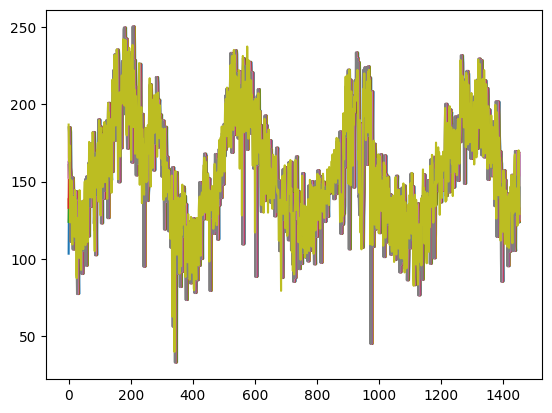

In [ ]:
xw_ajahuel=[i for i in range(len(yw_ajahuel))]
yp_ajahuel=model_ajahuel.predict(yw_ajahuel)
plt.plot(xw_ajahuel,yw_ajahuel,xw_ajahuel,yp_ajahuel)

1/1 [==============================] - 0s 39ms/step
129.10606
1/1 [==============================] - 0s 28ms/step
138.58841
1/1 [==============================] - 0s 22ms/step
145.13316
1/1 [==============================] - 0s 22ms/step
140.24715
1/1 [==============================] - 0s 23ms/step
148.81738
1/1 [==============================] - 0s 21ms/step
153.81874
1/1 [==============================] - 0s 27ms/step
165.59769
1/1 [==============================] - 0s 82ms/step
163.1713
1/1 [==============================] - 0s 116ms/step
163.82327
1/1 [==============================] - 0s 58ms/step
151.23701
1/1 [==============================] - 0s 29ms/step
150.65144
1/1 [==============================] - 0s 25ms/step
145.95364
1/1 [==============================] - 0s 25ms/step
151.954
1/1 [==============================] - 0s 27ms/step
150.51562
1/1 [==============================] - 0s 24ms/step
155.24516
1/1 [==============================] - 0s 25ms/step
163.72371
1/1 [=====

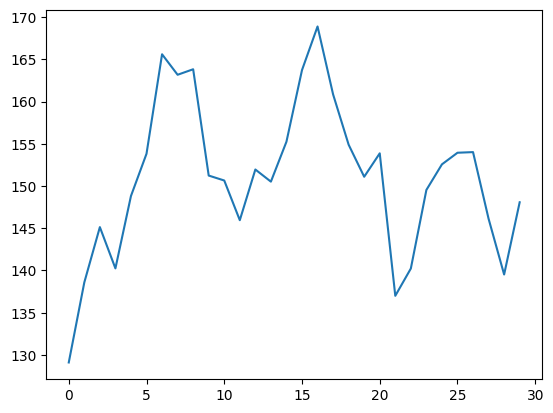

In [ ]:
ultimo_ajahuel=list(yw_ajahuel[-1].copy())
forecasts=[]
for i in range(30):
    data_ajahuel=np.array(np.asarray([ultimo_ajahuel]))
    forecast=model_ajahuel.predict(data_ajahuel)
    valor=forecast[0][0]
    print(valor)
    forecasts.append(valor)
    ultimo_ajahuel.pop(0)
    ultimo_ajahuel.append(valor)
plt.plot(forecasts)

In [ ]:
#entrega de datos desordenados
tag="rnn"+datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = "logs/fit/" + tag
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
optimizer=Adam(learning_rate=1e-3)

callbacks = [tensorboard_callback, early_stopping]
model_ajahuel.compile(optimizer="Adam", loss='mse', metrics=['mse','mae','mape'])
rnn = model_ajahuel.fit(yw_ajahuel, yt_ajahuel, batch_size=300, epochs=500,shuffle=True,verbose=1,callbacks=callbacks)
model_ajahuel.save(log_dir+'/model_{0}.keras'.format(tag))

Epoch 1/500
5/5 [==============================] - 3s 75ms/step - loss: 386.0209 - mse: 386.0209 - mae: 14.3250 - mape: 9.7677
Epoch 2/500
5/5 [==============================] - 0s 61ms/step - loss: 274.7249 - mse: 274.7249 - mae: 12.5050 - mape: 8.8569
Epoch 3/500
5/5 [==============================] - 0s 58ms/step - loss: 251.6289 - mse: 251.6289 - mae: 12.0645 - mape: 8.0851
Epoch 4/500
5/5 [==============================] - 0s 57ms/step - loss: 241.5577 - mse: 241.5577 - mae: 11.1446 - mape: 7.9173
Epoch 5/500
5/5 [==============================] - 0s 53ms/step - loss: 192.0224 - mse: 192.0224 - mae: 10.3720 - mape: 7.0133
Epoch 6/500
5/5 [==============================] - 0s 64ms/step - loss: 165.3644 - mse: 165.3644 - mae: 9.5315 - mape: 6.7064
Epoch 7/500
5/5 [==============================] - 0s 54ms/step - loss: 142.8146 - mse: 142.8146 - mae: 8.9086 - mape: 6.1705
Epoch 8/500
5/5 [==============================] - 0s 56ms/step - loss: 130.1312 - mse: 130.1312 - mae: 8.4468 - 

46/46 [==============================] - 1s 9ms/step


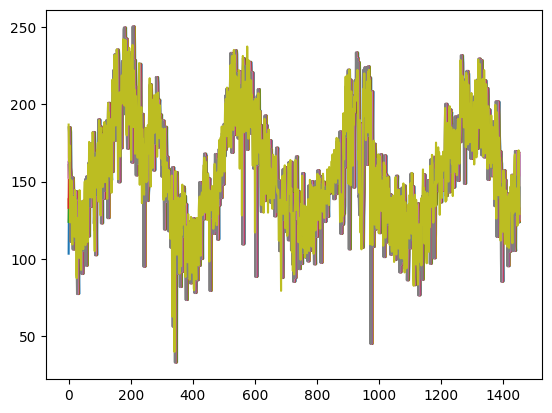

In [ ]:
xw_ajahuel=[i for i in range(len(yw_ajahuel))]
yp=model_ajahuel.predict(yw_ajahuel)
plt.plot(xw_ajahuel,yw_ajahuel,xw_ajahuel,yp_ajahuel)

1/1 [==============================] - 0s 204ms/step
127.07756
1/1 [==============================] - 0s 204ms/step
133.22589
1/1 [==============================] - 0s 218ms/step
146.12215
1/1 [==============================] - 0s 206ms/step
135.56146
1/1 [==============================] - 0s 183ms/step
147.90814
1/1 [==============================] - 0s 83ms/step
162.05933
1/1 [==============================] - 0s 123ms/step
176.79984
1/1 [==============================] - 0s 52ms/step
173.13615
1/1 [==============================] - 0s 89ms/step
168.481
1/1 [==============================] - 0s 71ms/step
148.83519
1/1 [==============================] - 0s 64ms/step
155.23637
1/1 [==============================] - 0s 143ms/step
145.13184
1/1 [==============================] - 0s 85ms/step
157.87527
1/1 [==============================] - 0s 123ms/step
155.76868
1/1 [==============================] - 0s 175ms/step
164.14914
1/1 [==============================] - 0s 115ms/step
167.95636


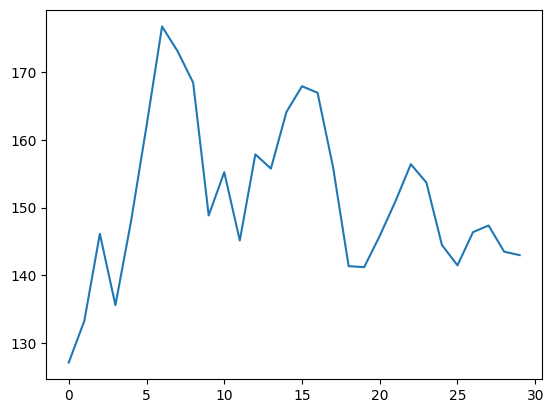

In [ ]:
ultimo_ajahuel=list(yw_ajahuel[-1].copy())
forecasts=[]
for i in range(30):
    data_ajahuel=np.array(np.asarray([ultimo_ajahuel]))
    forecast=model_ajahuel.predict(data_ajahuel)
    valor=forecast[0][0]
    print(valor)
    forecasts.append(valor)
    ultimo_ajahuel.pop(0)
    ultimo_ajahuel.append(valor)
plt.plot(forecasts)

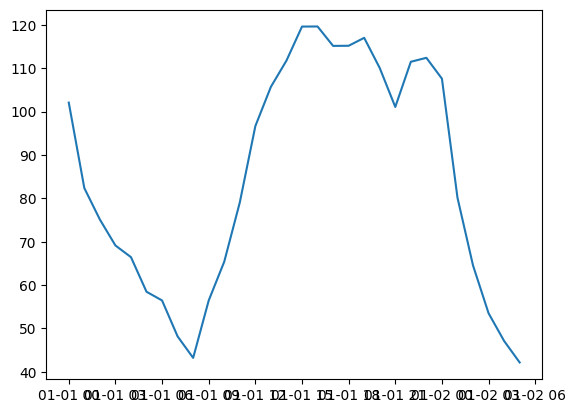

In [ ]:
yt_ajahuel=ds_test.query(filtro)["Consumo"]
xt_ajahuel=ds_test.query(filtro).index
plt.plot(xt_ajahuel[:30],yt_ajahuel[:30])

**Modelo Percetron Multicapa**

In [ ]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Preparar los datos de entrenamiento
X_train = x_ajahuel.values.reshape(-1, 1)  # Usar la fecha como característica
y_train = y_ajahuel.values.ravel()  # Aplanar y convertir a un arreglo unidimensional

# Crear y entrenar el modelo MLP
model = MLPRegressor(hidden_layer_sizes=(100, 50), activation='relu', solver='adam', max_iter=1000)
model.fit(X_train, y_train)

X_test = yt_ajahuel.values.reshape(-1, 1)  # Usar los datos de 'Consumo' para el conjunto de prueba
predictions = model.predict(X_test)

# Calcular el error cuadrático medio
mse = mean_squared_error(yt_ajahuel, predictions)

# Calcular el error absoluto medio
mae = mean_absolute_error(yt_ajahuel, predictions)

# Calcular R^2
r2 = r2_score(yt_ajahuel, predictions)

# Calcular MAPE
mape = np.mean(np.abs((yt_ajahuel - predictions) / yt_ajahuel)) * 100

print(f'Error cuadrático medio: {mse}')
print(f'Error absoluto medio: {mae}')
print(f'R^2: {r2}')

Error cuadrático medio: 49116.674121076416
Error absoluto medio: 200.81530560946928
R^2: -4.580861262961347


In [ ]:
#corregir para la parte 2
percentiles = consumo['Consumo'].describe(percentiles=[0.25, 0.5, 0.75])

print("\nPercentiles:")
print(percentiles)


Percentiles:
count    387072.000000
mean        187.374179
std         171.971795
min       -1317.000000
25%           2.152234
50%         173.045668
75%         270.713210
max        1610.284029
Name: Consumo, dtype: float64


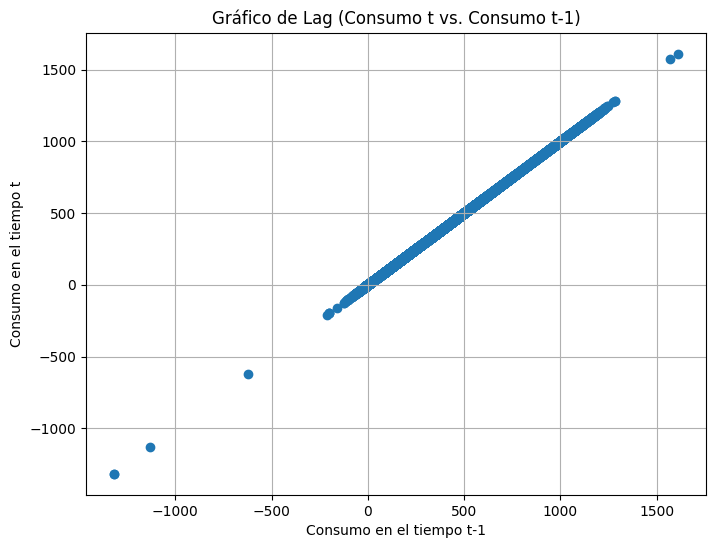

In [ ]:
# corregir gráfico
plt.figure(figsize=(8, 6))
plt.scatter(consumo['Consumo'], consumo['Consumo'])
plt.title('Gráfico de Lag (Consumo t vs. Consumo t-1)')
plt.xlabel('Consumo en el tiempo t-1')
plt.ylabel('Consumo en el tiempo t')
plt.grid(True)
plt.show()

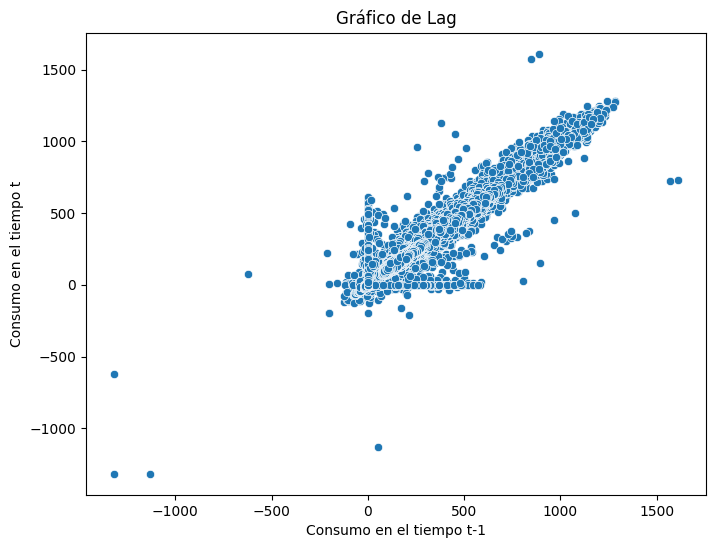

In [ ]:
#corregir gráfico
plt.figure(figsize=(8, 6))
sns.scatterplot(x=consumo['Consumo'].shift(1), y=consumo['Consumo'])
plt.title('Gráfico de Lag')
plt.xlabel('Consumo en el tiempo t-1')
plt.ylabel('Consumo en el tiempo t')
plt.show()

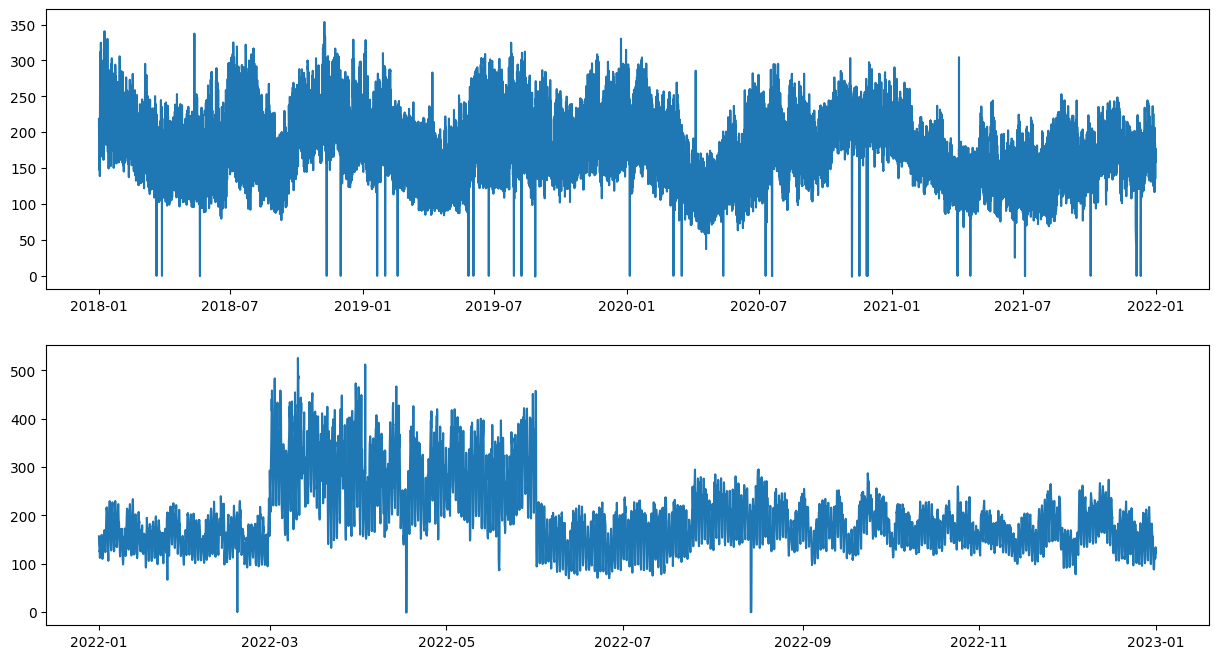

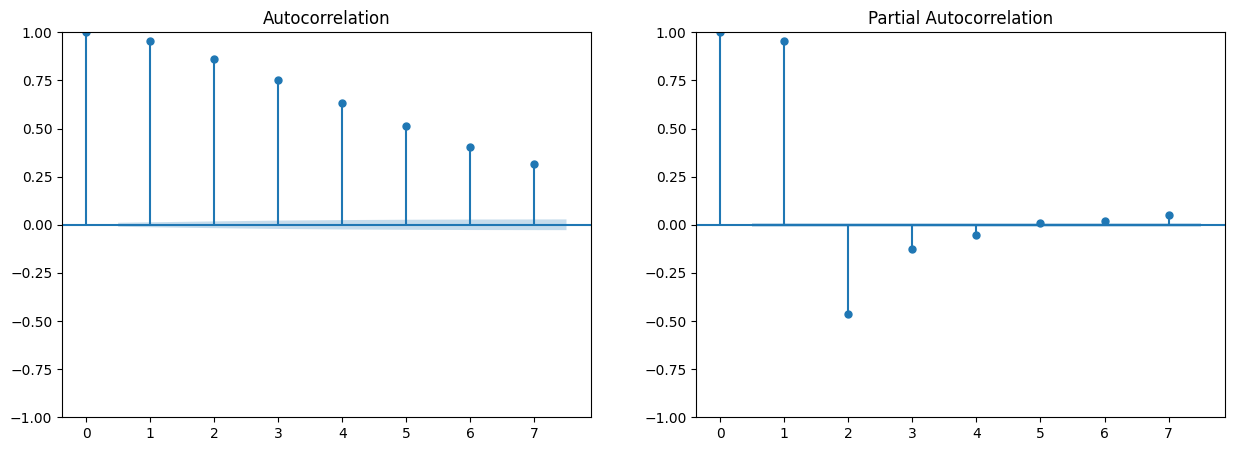

In [10]:
subestacion='LOSALME'
filtro="Barra=='{0}'".format(subestacion)
y_losalme=ds_train.query(filtro)["Consumo"]
x_losalme=ds_train.query(filtro).index
yt_losalme=ds_test.query(filtro)["Consumo"]
xt_losalme=ds_test.query(filtro).index
fig, axes = plt.subplots(2,1)
fig.set_size_inches(15, 8)
axes[0].plot(x_losalme,y_losalme);
axes[1].plot(xt_losalme,yt_losalme);
fig, axes = plt.subplots(1,2)
fig.set_size_inches(15, 5)
plot_acf(y_losalme,lags=7,ax=axes[0]);
plot_pacf(y_losalme,lags=7,method="ywm",ax=axes[1]);

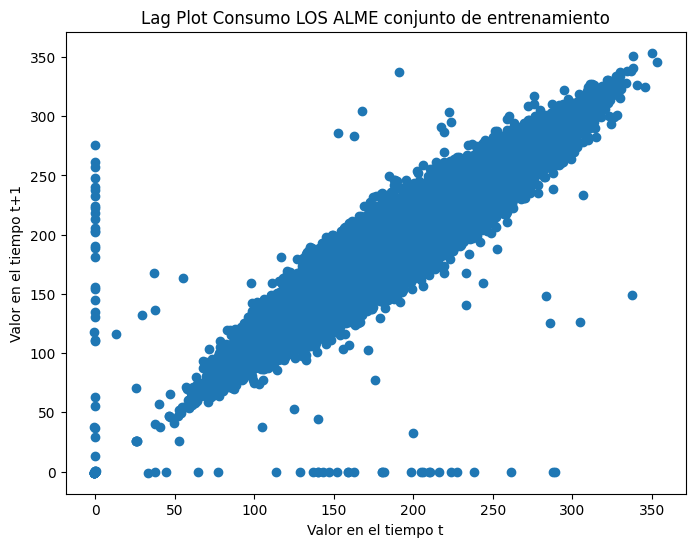

In [11]:
plt.figure(figsize=(8, 6))
lag_plot(y_losalme, lag=1)  # Puedes ajustar el valor de 'lag' según tus necesidades
plt.title('Lag Plot Consumo LOS ALME conjunto de entrenamiento')
plt.xlabel('Valor en el tiempo t')
plt.ylabel('Valor en el tiempo t+1')
plt.show()

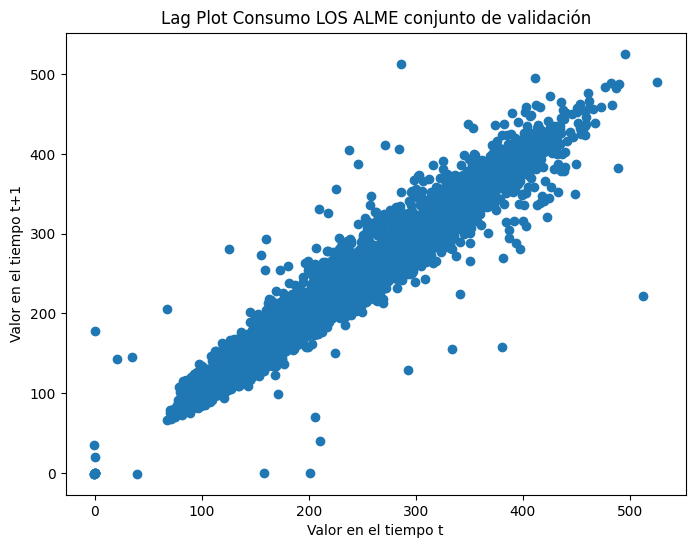

In [12]:
plt.figure(figsize=(8, 6))
lag_plot(yt_losalme, lag=1)  # Puedes ajustar el valor de 'lag' según tus necesidades
plt.title('Lag Plot Consumo LOS ALME conjunto de validación')
plt.xlabel('Valor en el tiempo t')
plt.ylabel('Valor en el tiempo t+1')
plt.show()

<Axes: xlabel='Hora', ylabel='Consumo'>

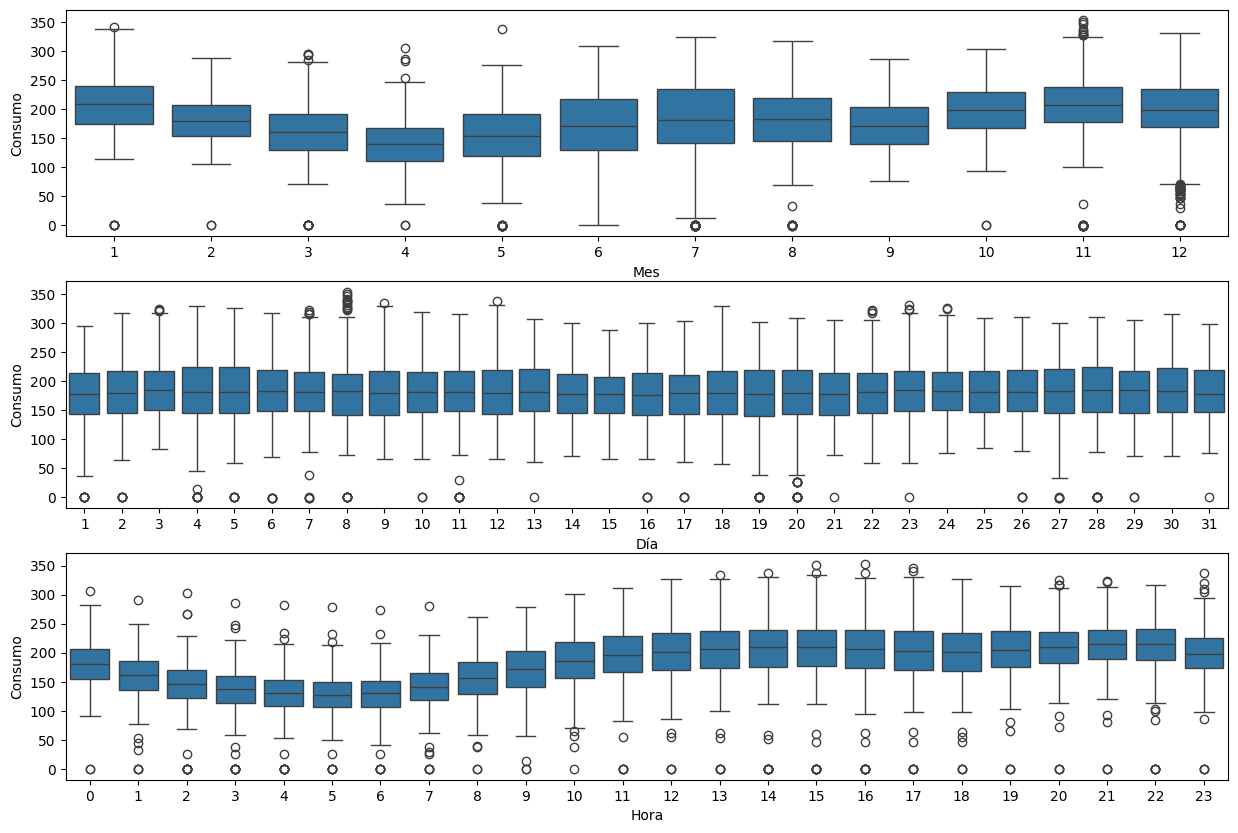

In [13]:
data_losalme=pd.DataFrame()
data_losalme["Consumo"]=y_losalme
data_losalme["Date"]=y_losalme.index
data_losalme["Día"]=data_losalme["Date"].dt.day
data_losalme["Hora"]=data_losalme["Date"].dt.hour
data_losalme["Mes"]=data_losalme["Date"].dt.month

fig, axes = plt.subplots(3,1)
fig.set_size_inches(15, 10)

sns.boxplot(x="Mes", y="Consumo", data=data_losalme, ax=axes[0])
sns.boxplot(x="Día", y="Consumo", data=data_losalme, ax=axes[1])
sns.boxplot(x="Hora", y="Consumo", data=data_losalme, ax=axes[2])

In [14]:
data_losalme["Año"]=data_losalme["Date"].dt.year
data_losalme

,Consumo,Date,Día,Hora,Mes,Año
Date,,,,,,
2018-01-01 00:00:00,218.675048,2018-01-01 00:00:00,1,0,1,2018
2018-01-01 01:00:00,202.256765,2018-01-01 01:00:00,1,1,1,2018
2018-01-01 02:00:00,195.217009,2018-01-01 02:00:00,1,2,1,2018
2018-01-01 03:00:00,181.340299,2018-01-01 03:00:00,1,3,1,2018
2018-01-01 04:00:00,172.410573,2018-01-01 04:00:00,1,4,1,2018
...,...,...,...,...,...,...
2021-12-31 19:00:00,168.644175,2021-12-31 19:00:00,31,19,12,2021
2021-12-31 20:00:00,171.593959,2021-12-31 20:00:00,31,20,12,2021
2021-12-31 21:00:00,160.167061,2021-12-31 21:00:00,31,21,12,2021


In [15]:
data_ys_losalme=data_losalme[["Año","Mes","Día","Consumo"]].groupby(["Año","Mes","Día"]).agg("mean")
data_ys_losalme.to_csv("data_ys_losalme.csv")

In [16]:
ys_losalme=[]
xs_losalme=[]
archivo=open("data_ys_losalme.csv")
archivo.readline()
for linea in archivo:
    linea=linea.strip().split(",")
    ys_losalme.append(float(linea[3]))
    fecha=str(linea[0])+"-"+str(linea[1]).zfill(2)+"-"+str(linea[2]).zfill(2)
    xs_losalme.append(datetime.strptime(fecha,"%Y-%m-%d"))

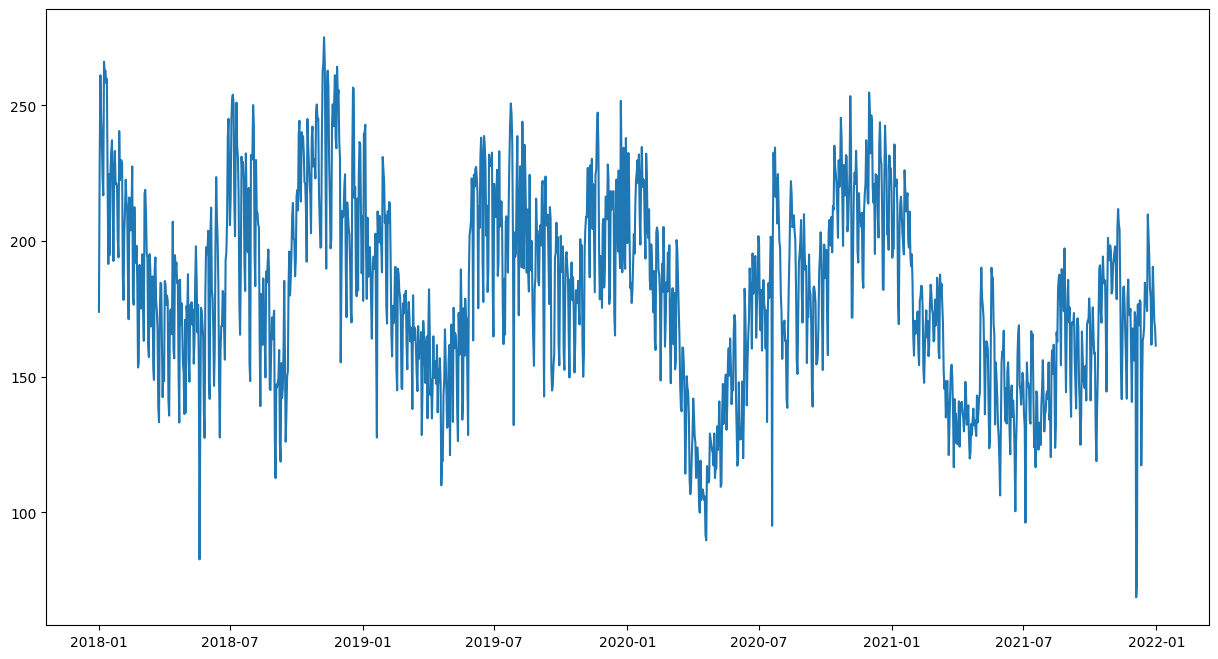

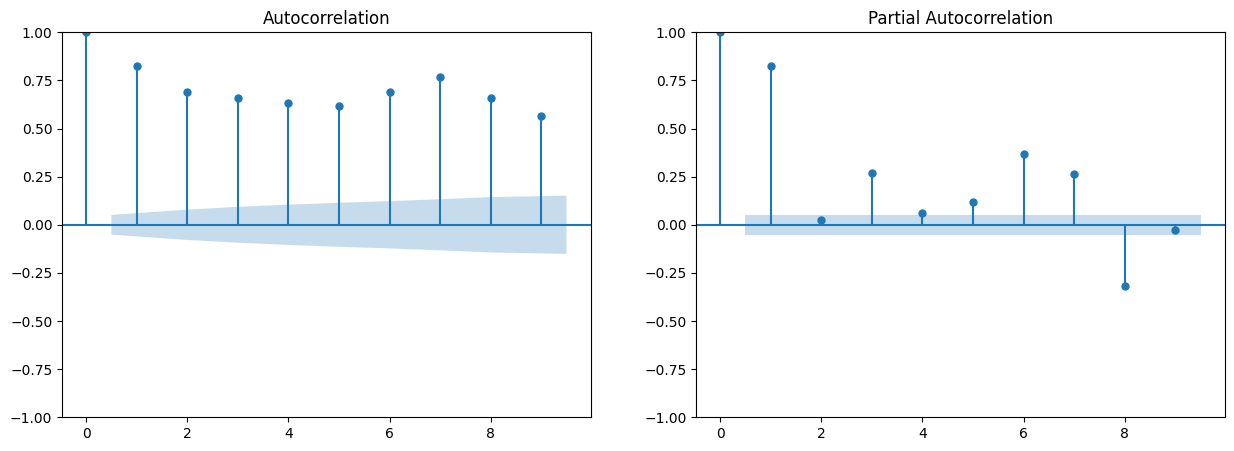

In [17]:
fig, axes = plt.subplots(1,1)
fig.set_size_inches(15, 8)
axes.plot(xs_losalme,ys_losalme);
fig, axes = plt.subplots(1,2)
fig.set_size_inches(15, 5)
plot_acf(ys_losalme,lags=9,ax=axes[0]);
plot_pacf(ys_losalme,lags=9,method="ywm",ax=axes[1]);

In [18]:
result = kpss(ys_losalme)

# Imprimir los resultados
print('KPSS Statistic:', result[0])
print('p-value:', result[1])
def funcion(x):
    if x<0.05:
        print("La serie no es estacionaria")
    else:
        print("La serie es estacionaria")
funcion(result[1])

KPSS Statistic: 0.9349532545761992
p-value: 0.01
La serie no es estacionaria


<ipython-input-18-0919672c3940>:1: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(ys_losalme)


In [19]:
# Calcula las diferencias entre valores sucesivos
diferencias = [ys_losalme[i] - ys_losalme[i-1] for i in range(1, len(ys_losalme))]

# Agrega un valor NaN al principio para mantener la longitud
diferencias.insert(0, float('nan'))
diferencias = pd.Series(diferencias)
diferencias = diferencias.dropna()

# Asigna las diferencias a una nueva variable en el DataFrame
ys_losalme = diferencias
ys_losalme = ys_losalme.values.tolist()
xs_losalme = xs_losalme[1:]
#diferencias_fechas = [(xs_losalme[i] - xs_losalme[i-1]).days for i in range(1, len(xs_losalme))]
# Agrega un valor NaN al principio para mantener la longitud
#diferencias_fechas.insert(0, float('nan'))
# Asigna las diferencias a una nueva variable en la lista
#diferencias_fechas = pd.Series(diferencias_fechas)
#diferencias_fechas = diferencias_fechas.dropna()
#xs_losalme = diferencias_fechas
#xs_losalme = xs_losalme.values.tolist()

In [20]:
result = kpss(ys_losalme)

# Imprimir los resultados
print('KPSS Statistic:', result[0])
print('p-value:', result[1])
def funcion(x):
    if x<0.05:
        print("La serie no es estacionaria")
    else:
        print("La serie es estacionaria")
funcion(result[1])

KPSS Statistic: 0.02803744986488948
p-value: 0.1
La serie es estacionaria


<ipython-input-20-0919672c3940>:1: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(ys_losalme)


**Modelo ARIMA**

In [ ]:
modelo_losalme_d=ARIMA(ys_losalme,order=(7,0,7))
m_ad1_losalme=modelo_losalme_d.fit()
print("MSE",m_ad1_losalme.mse)
print("AIC",m_ad1_losalme.aic)
ysp_losalme=m_ad1_losalme.predict()
mape=mean_absolute_percentage_error(ys_losalme,ysp_losalme)
print("MAPE",mape)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


MSE 216.13695716913622
AIC 12010.371156257685
MAPE 63.57052104008615


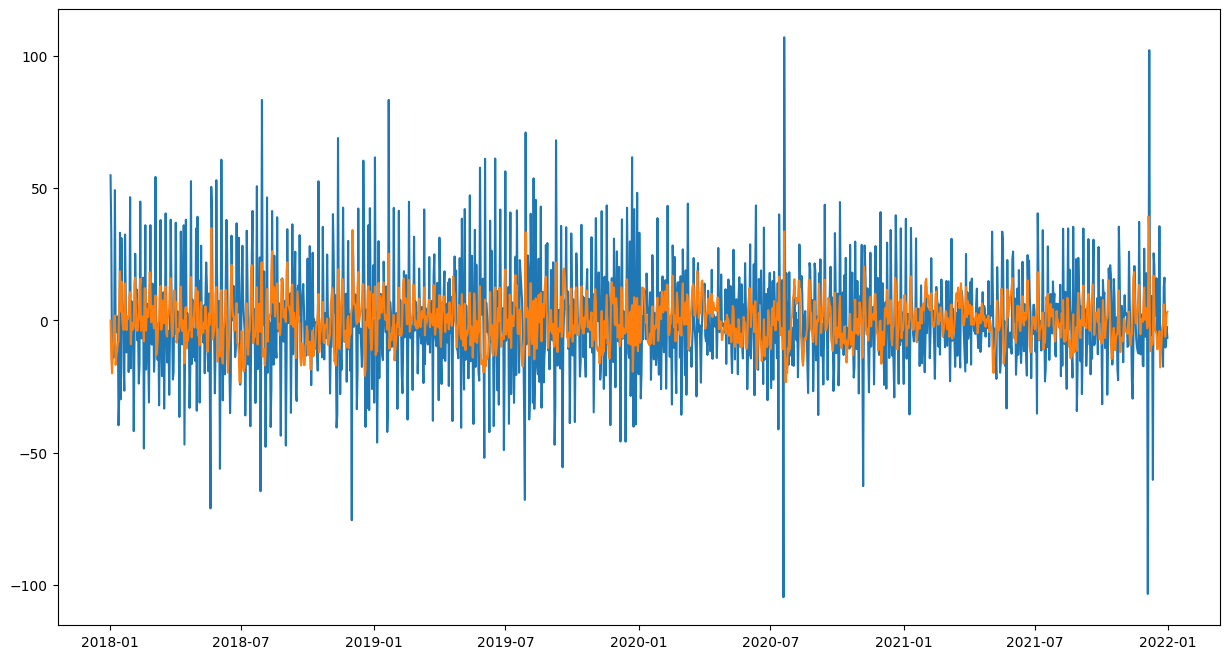

In [ ]:
fig, axes = plt.subplots(1,1)
fig.set_size_inches(15, 8)
axes.plot(xs_losalme,ys_losalme,xs_losalme,ysp_losalme);

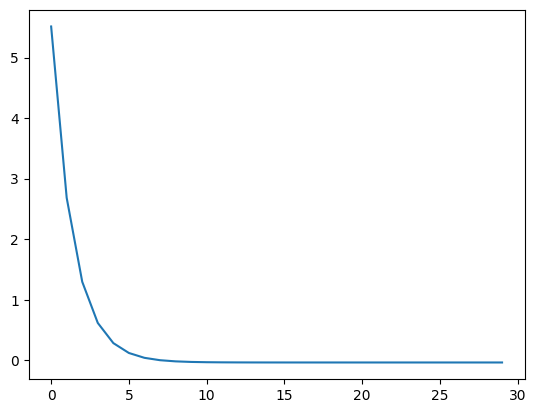

In [ ]:
m1_y1_p = m_ad1_losalme.get_forecast(steps=30)
m1_y1_ci = m_ad1_losalme.conf_int(0.05)
plt.plot(m1_y1_p.predicted_mean)

**Modelo Redes neuronales RNN**

In [ ]:
yw_losalme=[]
yt_losalme=[]
window=8
for i in range(0,len(ys_losalme)):
    if i+window < len(ys_losalme):
        row=[]
        for j in range(window):
            row.append(ys_losalme[i+j])
        yw_losalme.append(row)
        yt_losalme.append(ys_losalme[i+window])
    else:
        break
print(len(yw_losalme))

1452


In [ ]:
yw_losalme=np.asarray(yw_losalme)
yt_losalme=np.asarray(yt_losalme)

In [ ]:
seed=12122008
rd.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='mape', patience=30, restore_best_weights=True)

model_losalme = Sequential()
model_losalme.add(Input(name="serie",shape=(8,1)))
model_losalme.add(SimpleRNN(256))
model_losalme.add(Dense(128))
model_losalme.add(Dense(1, activation='linear'))
model_losalme.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_19 (SimpleRNN)   (None, 256)               66048     
                                                                 
 dense_38 (Dense)            (None, 128)               32896     
                                                                 
 dense_39 (Dense)            (None, 1)                 129       
                                                                 
Total params: 99073 (387.00 KB)
Trainable params: 99073 (387.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
tag="rnn"+datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = "logs/fit/" + tag
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
optimizer=Adam(learning_rate=1e-3)

callbacks = [tensorboard_callback, early_stopping]
model_losalme.compile(optimizer="Adam", loss='mse', metrics=['mse','mae','mape'])
rnn = model_losalme.fit(yw_losalme, yt_losalme, batch_size=256, epochs=177, verbose=1, callbacks=callbacks)
model_losalme.save(log_dir + '/model_{0}.keras'.format(tag))

Epoch 1/177
6/6 [==============================] - 2s 41ms/step - loss: 111.4342 - mse: 111.4342 - mae: 7.3094 - mape: 6785.7549
Epoch 2/177
6/6 [==============================] - 0s 41ms/step - loss: 53.0844 - mse: 53.0844 - mae: 5.7536 - mape: 10076.1973
Epoch 3/177
6/6 [==============================] - 0s 42ms/step - loss: 32.2873 - mse: 32.2873 - mae: 4.5398 - mape: 8258.1982
Epoch 4/177
6/6 [==============================] - 0s 43ms/step - loss: 24.7215 - mse: 24.7215 - mae: 3.8799 - mape: 9866.7578
Epoch 5/177
6/6 [==============================] - 0s 39ms/step - loss: 18.8842 - mse: 18.8842 - mae: 3.3891 - mape: 519.6638
Epoch 6/177
6/6 [==============================] - 0s 39ms/step - loss: 12.8991 - mse: 12.8991 - mae: 2.8232 - mape: 455.8734
Epoch 7/177
6/6 [==============================] - 0s 39ms/step - loss: 8.6372 - mse: 8.6372 - mae: 2.3346 - mape: 2402.9758
Epoch 8/177
6/6 [==============================] - 0s 43ms/step - loss: 5.7343 - mse: 5.7343 - mae: 1.8769 - map

46/46 [==============================] - 0s 5ms/step


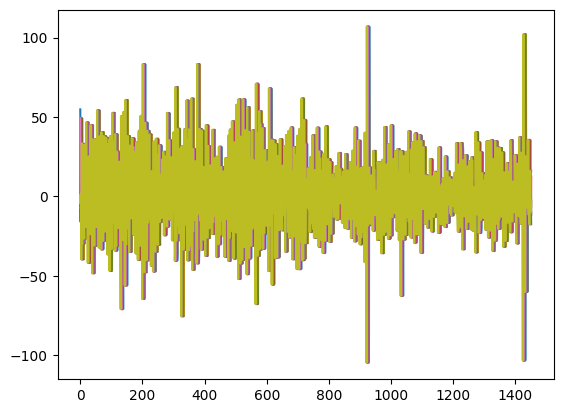

In [ ]:
xw_losalme=[i for i in range(len(yw_losalme))]
yp_losalme=model_losalme.predict(yw_losalme)
plt.plot(xw_losalme,yw_losalme,xw_losalme,yp_losalme)

1/1 [==============================] - 0s 23ms/step
-6.5308185
1/1 [==============================] - 0s 25ms/step
14.993885
1/1 [==============================] - 0s 21ms/step
-10.653334
1/1 [==============================] - 0s 23ms/step
12.246241
1/1 [==============================] - 0s 25ms/step
10.766384
1/1 [==============================] - 0s 25ms/step
-7.1341014
1/1 [==============================] - 0s 26ms/step
-7.5251455
1/1 [==============================] - 0s 24ms/step
-11.133755
1/1 [==============================] - 0s 27ms/step
13.5993
1/1 [==============================] - 0s 27ms/step
-6.1825557
1/1 [==============================] - 0s 22ms/step
5.8430142
1/1 [==============================] - 0s 22ms/step
-2.5492988
1/1 [==============================] - 0s 24ms/step
10.838069
1/1 [==============================] - 0s 21ms/step
-24.968079
1/1 [==============================] - 0s 22ms/step
10.39617
1/1 [==============================] - 0s 37ms/step
14.938447
1/1

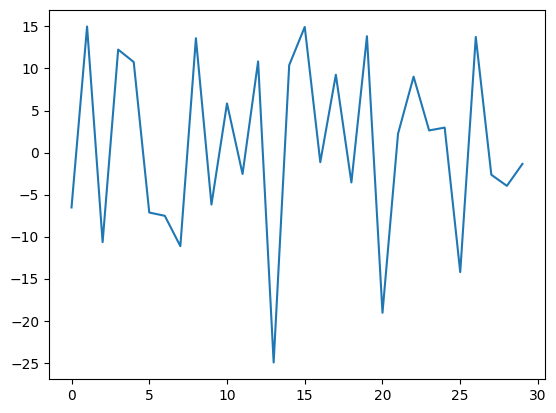

In [ ]:
ultimo_losalme=list(yw_losalme[-1].copy())
forecasts=[]
for i in range(30):
    data_losalme=np.array(np.asarray([ultimo_losalme]))
    forecast=model_losalme.predict(data_losalme)
    valor=forecast[0][0]
    print(valor)
    forecasts.append(valor)
    ultimo_losalme.pop(0)
    ultimo_losalme.append(valor)
plt.plot(forecasts)

In [ ]:
#entrega de datos desordenados
tag="rnn"+datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = "logs/fit/" + tag
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
optimizer=Adam(learning_rate=1e-3)

callbacks = [tensorboard_callback, early_stopping]
model_losalme.compile(optimizer="Adam", loss='mse', metrics=['mse','mae','mape'])
rnn = model_losalme.fit(yw_losalme, yt_losalme, batch_size=256, epochs=177,shuffle=True,verbose=1,callbacks=callbacks)
model_losalme.save(log_dir+'/model_{0}.keras'.format(tag))

Epoch 1/177
6/6 [==============================] - 2s 43ms/step - loss: 85.1924 - mse: 85.1924 - mae: 6.4462 - mape: 2538.2368
Epoch 2/177
6/6 [==============================] - 0s 43ms/step - loss: 45.1428 - mse: 45.1428 - mae: 5.2812 - mape: 6900.4048
Epoch 3/177
6/6 [==============================] - 0s 45ms/step - loss: 26.8349 - mse: 26.8349 - mae: 4.1237 - mape: 6209.9731
Epoch 4/177
6/6 [==============================] - 0s 46ms/step - loss: 21.1272 - mse: 21.1272 - mae: 3.6597 - mape: 3487.7078
Epoch 5/177
6/6 [==============================] - 0s 51ms/step - loss: 14.1707 - mse: 14.1707 - mae: 2.9571 - mape: 3277.8982
Epoch 6/177
6/6 [==============================] - 0s 43ms/step - loss: 7.9612 - mse: 7.9612 - mae: 2.2389 - mape: 2591.2339
Epoch 7/177
6/6 [==============================] - 0s 43ms/step - loss: 4.5404 - mse: 4.5404 - mae: 1.6965 - mape: 988.1855
Epoch 8/177
6/6 [==============================] - 0s 40ms/step - loss: 3.1679 - mse: 3.1679 - mae: 1.3921 - mape: 5

46/46 [==============================] - 0s 4ms/step


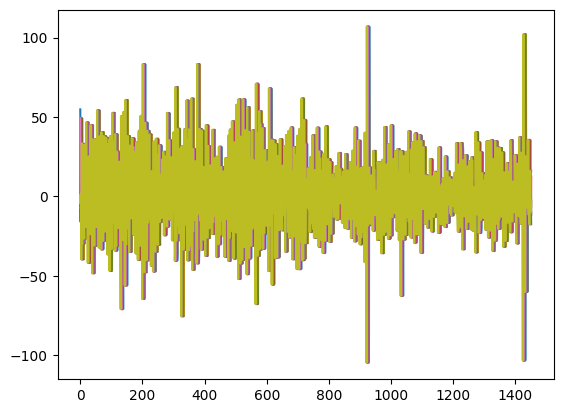

In [ ]:
xw_losalme=[i for i in range(len(yw_losalme))]
yp=model_losalme.predict(yw_losalme)
plt.plot(xw_losalme,yw_losalme,xw_losalme,yp_losalme)

1/1 [==============================] - 0s 23ms/step
-6.631543
1/1 [==============================] - 0s 23ms/step
14.363799
1/1 [==============================] - 0s 24ms/step
-10.084172
1/1 [==============================] - 0s 25ms/step
13.253093
1/1 [==============================] - 0s 28ms/step
5.527039
1/1 [==============================] - 0s 32ms/step
-5.272882
1/1 [==============================] - 0s 27ms/step
0.5485281
1/1 [==============================] - 0s 28ms/step
-5.789492
1/1 [==============================] - 0s 29ms/step
-2.3756528
1/1 [==============================] - 0s 32ms/step
-3.8447244
1/1 [==============================] - 0s 24ms/step
9.927281
1/1 [==============================] - 0s 25ms/step
-0.46302223
1/1 [==============================] - 0s 25ms/step
-9.551837
1/1 [==============================] - 0s 26ms/step
19.710943
1/1 [==============================] - 0s 27ms/step
-10.109549
1/1 [==============================] - 0s 27ms/step
-2.9330623
1/1

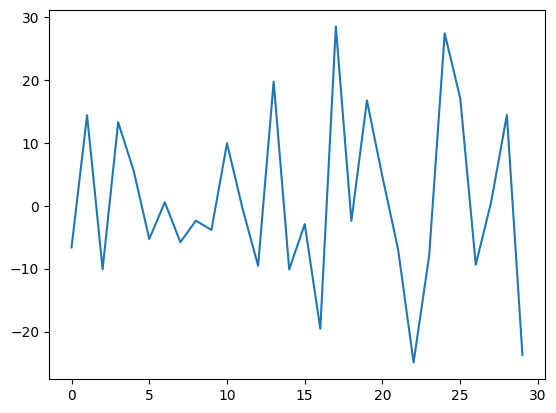

In [ ]:
ultimo_losalme=list(yw_losalme[-1].copy())
forecasts=[]
for i in range(30):
    data_losalme=np.array(np.asarray([ultimo_losalme]))
    forecast=model_losalme.predict(data_losalme)
    valor=forecast[0][0]
    print(valor)
    forecasts.append(valor)
    ultimo_losalme.pop(0)
    ultimo_losalme.append(valor)
plt.plot(forecasts)

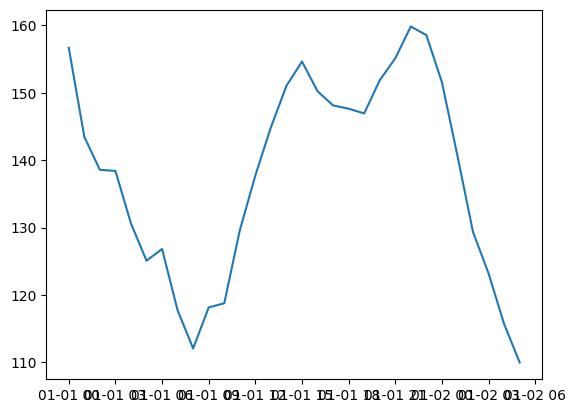

In [ ]:
yt_losalme=ds_test.query(filtro)["Consumo"]
xt_losalme=ds_test.query(filtro).index
plt.plot(xt_losalme[:30],yt_losalme[:30])


In [21]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Preparar los datos de entrenamiento
X_train = x_losalme.values.reshape(-1, 1)  # Usar la fecha como característica
y_train = y_losalme.values.ravel()  # Aplanar y convertir a un arreglo unidimensional

# Crear y entrenar el modelo MLP
model = MLPRegressor(hidden_layer_sizes=(100, 50), activation='relu', solver='adam', max_iter=1000)
model.fit(X_train, y_train)

X_test = yt_losalme.values.reshape(-1, 1)  # Usar los datos de 'Consumo' para el conjunto de prueba
predictions = model.predict(X_test)

# Calcular el error cuadrático medio
mse = mean_squared_error(yt_losalme, predictions)

# Calcular el error absoluto medio
mae = mean_absolute_error(yt_losalme, predictions)

# Calcular R^2
r2 = r2_score(yt_losalme, predictions)

# Calcular MAPE
mape = np.mean(np.abs((yt_losalme - predictions) / yt_losalme)) * 100

print(f'Error cuadrático medio: {mse}')
print(f'Error absoluto medio: {mae}')
print(f'R^2: {r2}')

Error cuadrático medio: 46300.47947410281
Error absoluto medio: 201.59665267108102
R^2: -7.180490644593823
